In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Load the two CSVs and add a column to distinguish them
df_warm = pd.read_csv("results_warmup.csv")
df_warm["warmup"] = "warmup"
df_no = pd.read_csv("results_nowarmup.csv")
df_no["warmup"] = "no_warmup"

# Combine into a single DataFrame
df = pd.concat([df_warm, df_no], ignore_index=True)

# Convert n to numeric and work in log-space for x-axis
df["log_n"] = np.log2(df["n"])
df.head()

,n,max_levels,k,cpu_ms,cublas_kernel_ms,cublas_total_ms,gpu_kernel_ms,gpu_total_ms,ops_cublas,ops_gpu,gflops_cublas,gflops_gpu,relerr_cublas,relerr_custom,warmup,log_n
0,128,2,6,0.014861,0.021372,24.512375,0.059396,0.507136,32768,14336,1.547251,0.243122,2.080000e-07,2.180000e-07,warmup,7.0
1,128,2,8,0.013337,0.022016,24.007313,0.060676,0.484868,32768,16384,1.492209,0.270950,2.050000e-07,2.250000e-07,warmup,7.0
2,128,2,10,0.012205,0.020224,21.651325,0.056448,0.476416,32768,18432,1.624227,0.327194,2.070000e-07,2.180000e-07,warmup,7.0
3,128,2,12,0.012076,0.021504,23.092850,0.060928,0.489728,32768,20480,1.537670,0.339934,2.140000e-07,2.280000e-07,warmup,7.0
4,128,2,14,0.012588,0.022528,22.956537,0.059904,0.503936,32768,22528,1.474815,0.380638,1.910000e-07,2.200000e-07,warmup,7.0


In [4]:
df_warmup = df[df['warmup'] == 'warmup']
df_warmup.head()

,n,max_levels,k,cpu_ms,cublas_kernel_ms,cublas_total_ms,gpu_kernel_ms,gpu_total_ms,ops_cublas,ops_gpu,gflops_cublas,gflops_gpu,relerr_cublas,relerr_custom,warmup,log_n
0,128,2,6,0.014861,0.021372,24.512375,0.059396,0.507136,32768,14336,1.547251,0.243122,2.080000e-07,2.180000e-07,warmup,7.0
1,128,2,8,0.013337,0.022016,24.007313,0.060676,0.484868,32768,16384,1.492209,0.270950,2.050000e-07,2.250000e-07,warmup,7.0
2,128,2,10,0.012205,0.020224,21.651325,0.056448,0.476416,32768,18432,1.624227,0.327194,2.070000e-07,2.180000e-07,warmup,7.0
3,128,2,12,0.012076,0.021504,23.092850,0.060928,0.489728,32768,20480,1.537670,0.339934,2.140000e-07,2.280000e-07,warmup,7.0
4,128,2,14,0.012588,0.022528,22.956537,0.059904,0.503936,32768,22528,1.474815,0.380638,1.910000e-07,2.200000e-07,warmup,7.0


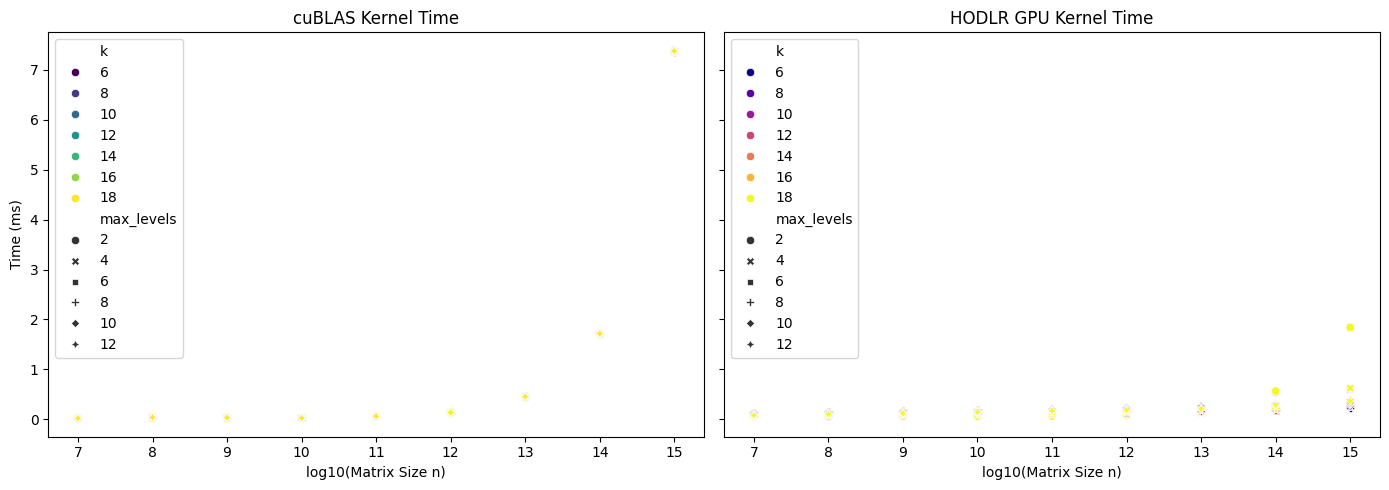

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# cuBLAS kernel time
sns.scatterplot(
    data=df_warmup, x="log_n", y="cublas_kernel_ms",
    hue="k", style="max_levels",
    palette="viridis", sizes=(20,200),
    ax=axs[0]
)
axs[0].set_title("cuBLAS Kernel Time")
axs[0].set_xlabel("log10(Matrix Size n)")
axs[0].set_ylabel("Time (ms)")

# HODLR GPU kernel time
sns.scatterplot(
    data=df_warmup, x="log_n", y="gpu_kernel_ms",
    hue="k", style="max_levels",
    palette="plasma", sizes=(20,200),
    ax=axs[1]
)
axs[1].set_title("HODLR GPU Kernel Time")
axs[1].set_xlabel("log10(Matrix Size n)")

plt.tight_layout()
plt.show()

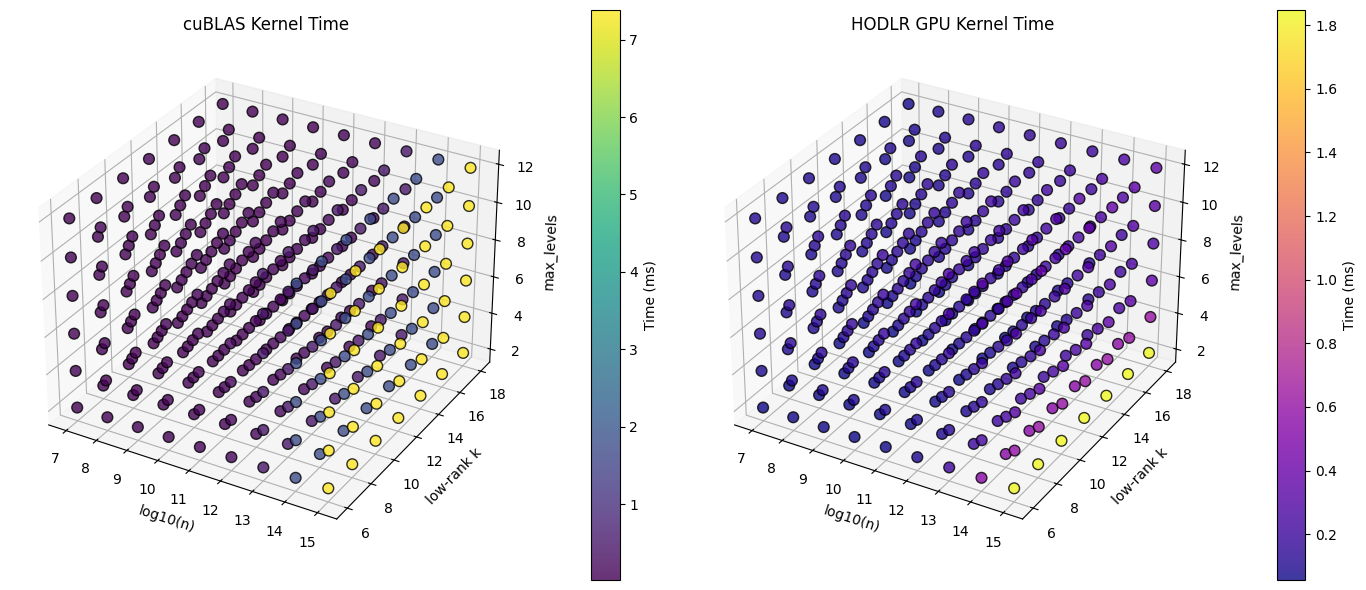

In [14]:

fig = plt.figure(figsize=(14, 6))

# 3D scatter for cuBLAS kernel time
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    df_warmup["log_n"], 
    df_warmup["k"], 
    df_warmup["max_levels"],
    c=df_warmup["cublas_kernel_ms"], 
    cmap="viridis",
    s=60,
    edgecolor="k",
    alpha=0.8
)
ax1.set_title("cuBLAS Kernel Time")
ax1.set_xlabel("log10(n)")
ax1.set_ylabel("low-rank k")
ax1.set_zlabel("max_levels")
cbar1 = fig.colorbar(sc1, ax=ax1, pad=0.1)
cbar1.set_label("Time (ms)")

# 3D scatter for HODLR GPU kernel time
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    df_warmup["log_n"], 
    df_warmup["k"], 
    df_warmup["max_levels"],
    c=df_warmup["gpu_kernel_ms"], 
    cmap="plasma",
    s=60,
    edgecolor="k",
    alpha=0.8
)
ax2.set_title("HODLR GPU Kernel Time")
ax2.set_xlabel("log10(n)")
ax2.set_ylabel("low-rank k")
ax2.set_zlabel("max_levels")
cbar2 = fig.colorbar(sc2, ax=ax2, pad=0.1)
cbar2.set_label("Time (ms)")

plt.tight_layout()
plt.show()

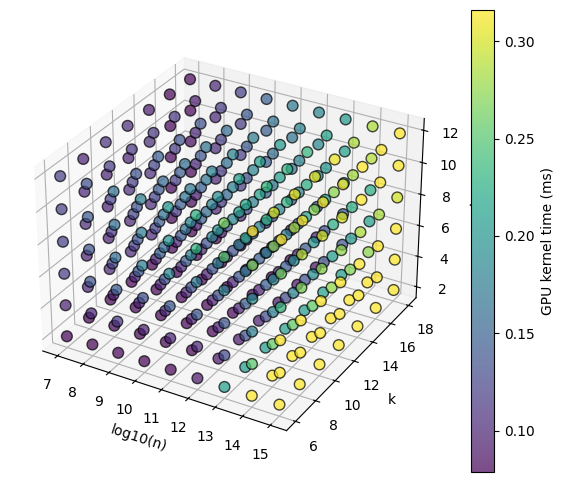

In [ ]:
times = df_warmup["gpu_kernel_ms"]
vmin, vmax = np.percentile(times, [10, 90])

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df_warmup["log_n"], df_warmup["k"], df_warmup["max_levels"],
    c=df_warmup["gpu_kernel_ms"],
    cmap="viridis",
    vmin=vmin,    # clamp the color‐map
    vmax=vmax,
    s=60, edgecolor="k", alpha=0.8
)
ax.set_xlabel("log10(n)")
ax.set_ylabel("k")
ax.set_zlabel("max_levels")
fig.colorbar(sc, ax=ax, label="GPU kernel time (ms)")
plt.show()

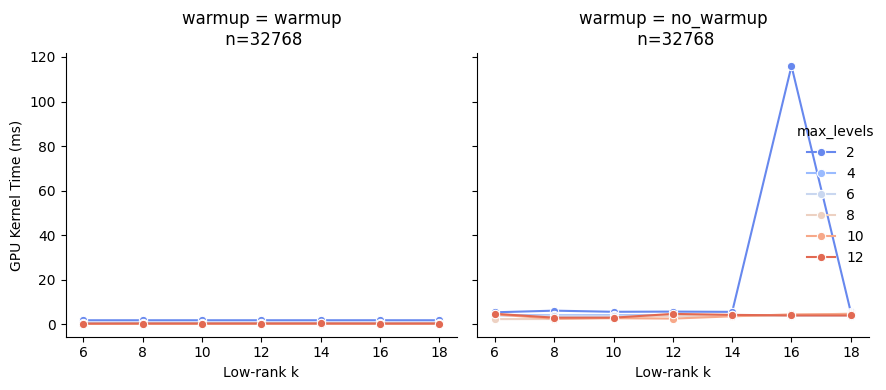

In [27]:
fixed_n = 32768
df_n = df[df["n"] == fixed_n]

g = sns.FacetGrid(
    df_n, col="warmup", height=4,
    hue="max_levels", palette="coolwarm"
)
g.map_dataframe(
    sns.lineplot, "k", "gpu_kernel_ms", marker="o"
)
g.add_legend(title="max_levels")

for ax in g.axes.flatten():
    # ax.set_xscale("log")
    ax.set_title(f"{ax.get_title()}\n n={fixed_n}")
    ax.set_xlabel("Low-rank k")
    ax.set_ylabel("GPU Kernel Time (ms)")

plt.tight_layout()

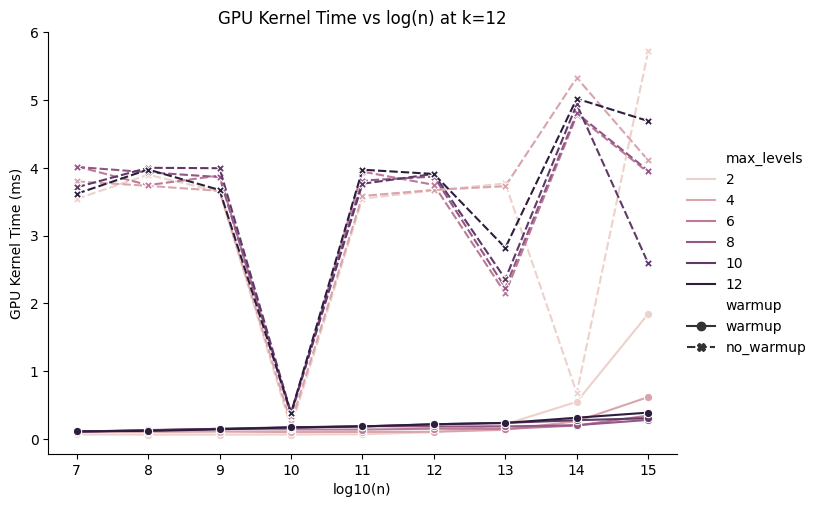

In [28]:
fixed_k = 12
df_k = df[df["k"] == fixed_k]

sns.relplot(
    data=df_k, x="log_n", y="gpu_kernel_ms",
    hue="max_levels", style="warmup", kind="line",
    markers=True, height=5, aspect=1.4
)
plt.title(f"GPU Kernel Time vs log(n) at k={fixed_k}")
plt.xlabel("log10(n)")
plt.ylabel("GPU Kernel Time (ms)")
plt.show()

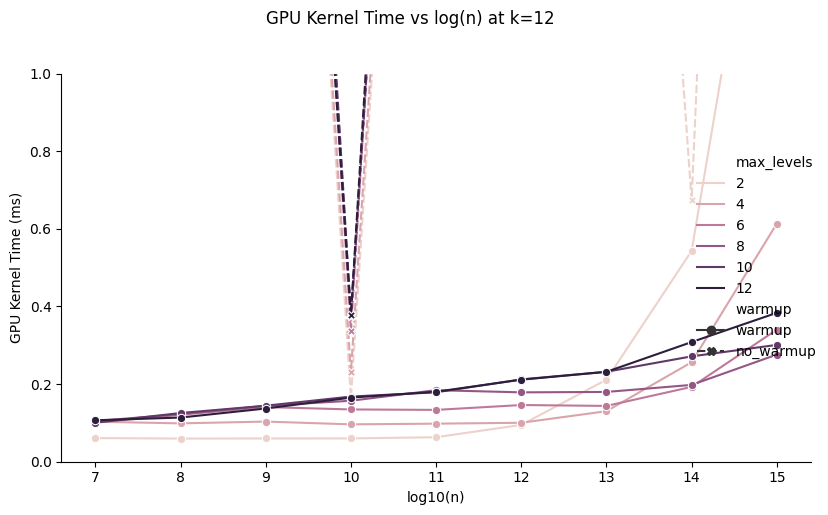

In [43]:
fixed_k = 12
df_k = df[df["k"] == fixed_k]

g = sns.relplot(
    data=df_k,
    x="log_n", y="gpu_kernel_ms",
    hue="max_levels", style="warmup", kind="line",
    markers=True, height=5, aspect=1.4
)
g.set(ylim=(0, 1.0))          # <— restrict y-axis to [0,1]
g.fig.suptitle(f"GPU Kernel Time vs log(n) at k={fixed_k}", y=1.02)
g.set_xlabels("log10(n)")
g.set_ylabels("GPU Kernel Time (ms)")

plt.tight_layout()
plt.show()

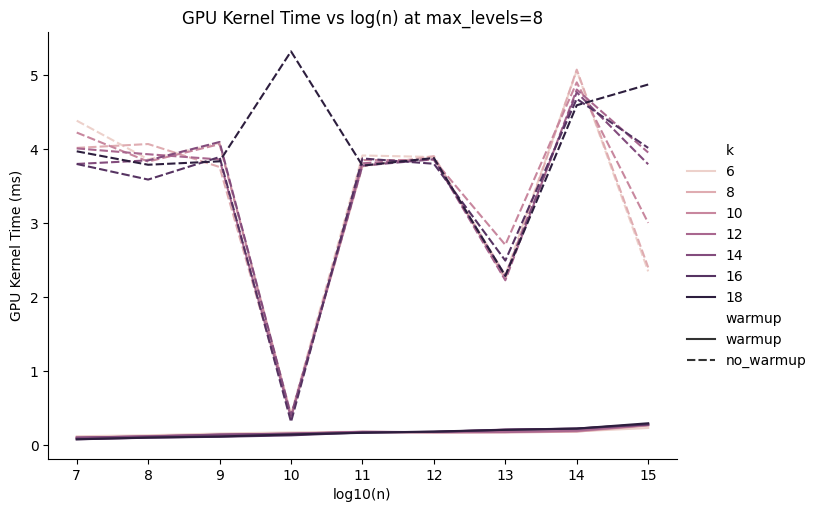

In [29]:
fixed_lvl = 8
df_lvl = df[df["max_levels"] == fixed_lvl]

sns.relplot(
    data=df_lvl, x="log_n", y="gpu_kernel_ms",
    hue="k", style="warmup", kind="line",
    height=5, aspect=1.4
)
plt.title(f"GPU Kernel Time vs log(n) at max_levels={fixed_lvl}")
plt.xlabel("log10(n)")
plt.ylabel("GPU Kernel Time (ms)")
plt.show()

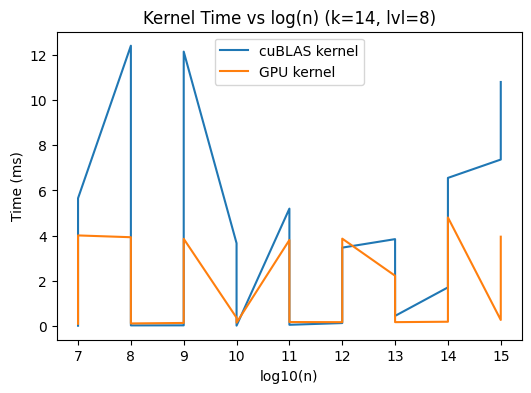

In [5]:
sel = (df["k"] == 12) & (df["max_levels"] == 8)
df_sel = df[sel].sort_values("n")

plt.figure(figsize=(6,4))
plt.plot(df_sel["log_n"], df_sel["cublas_kernel_ms"], label="cuBLAS kernel")
plt.plot(df_sel["log_n"], df_sel["gpu_kernel_ms"], label="GPU kernel")
plt.title("Kernel Time vs log(n) (k=14, lvl=8)")
plt.xlabel("log10(n)")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()

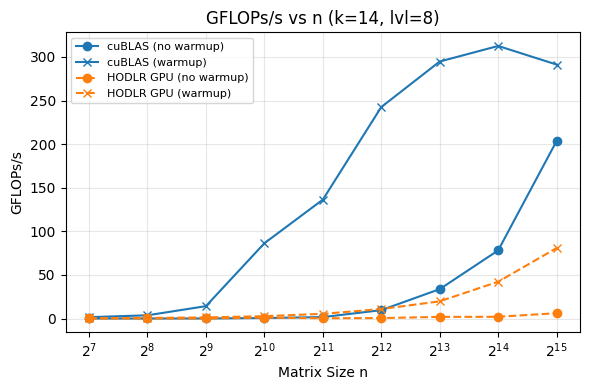

In [42]:
# select only k=14, lvl=8
sel = (df["k"] == 14) & (df["max_levels"] == 8)
df_sel = df[sel].sort_values("n")

# unpack
x     = df_sel["log_n"].values
y_cb  = df_sel["gflops_cublas"].values
y_gpu = df_sel["gflops_gpu"].values
# warm  = .values  # True/False array

# split into two sets per method
mask = df_sel["warmup"] == 'warmup'
x0, x1 = x[~mask], x[mask]
y0_cb, y1_cb   = y_cb[~mask],  y_cb[mask]
y0_gpu, y1_gpu = y_gpu[~mask], y_gpu[mask]

plt.figure(figsize=(6,4))

# cuBLAS: no warmup
plt.plot(x0, y0_cb,
         marker='o', linestyle='-',
         color='C0', label='cuBLAS (no warmup)')
# cuBLAS: with warmup
plt.plot(x1, y1_cb,
         marker='x', linestyle='-',
         color='C0', label='cuBLAS (warmup)')

# HODLR GPU: no warmup
plt.plot(x0, y0_gpu,
         marker='o', linestyle='--',
         color='C1', label='HODLR GPU (no warmup)')
# HODLR GPU: with warmup
plt.plot(x1, y1_gpu,
         marker='x', linestyle='--',
         color='C1', label='HODLR GPU (warmup)')

ax = plt.gca()
from matplotlib.ticker import FuncFormatter, MaxNLocator
# force integer ticks on the log2(n) axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# formatter: turn each tick x into "2^{x}"
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

plt.title("GFLOPs/s vs n (k=14, lvl=8)")
plt.xlabel("Matrix Size n")
plt.ylabel("GFLOPs/s")
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

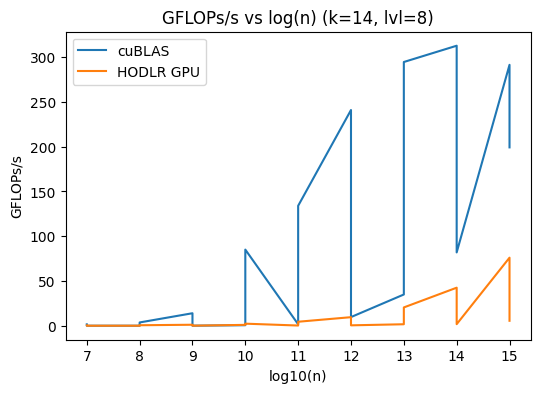

In [33]:
plt.figure(figsize=(6,4))
plt.plot(df_sel["log_n"], df_sel["gflops_cublas"], label="cuBLAS")
plt.plot(df_sel["log_n"], df_sel["gflops_gpu"],    label="HODLR GPU")
plt.title("GFLOPs/s vs log(n) (k=14, lvl=8)")
plt.xlabel("log10(n)")
plt.ylabel("GFLOPs/s")
plt.legend()
plt.show()

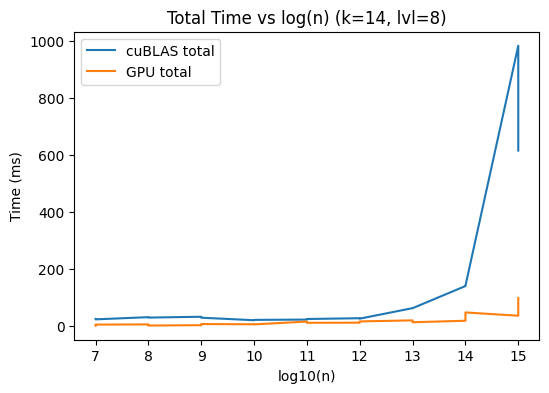

In [32]:
plt.figure(figsize=(6,4))
plt.plot(df_sel["log_n"], df_sel["cublas_total_ms"], label="cuBLAS total")
plt.plot(df_sel["log_n"], df_sel["gpu_total_ms"],    label="GPU total")
plt.title("Total Time vs log(n) (k=14, lvl=8)")
plt.xlabel("log10(n)")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()

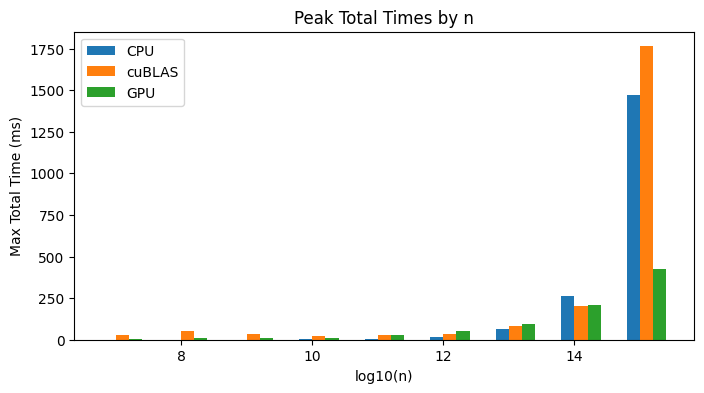

In [35]:
group = df.groupby("n").max().reset_index()
group["log_n"] = np.log2(group["n"])

plt.figure(figsize=(8,4))
plt.bar(group["log_n"]-0.1, group["cpu_ms"],    width=0.2, label="CPU")
plt.bar(group["log_n"]+0.1, group["cublas_total_ms"], width=0.2, label="cuBLAS")
plt.bar(group["log_n"]+0.3, group["gpu_total_ms"],      width=0.2, label="GPU")
plt.xlabel("log10(n)")
plt.ylabel("Max Total Time (ms)")
plt.legend()
plt.title("Peak Total Times by n")
plt.show()

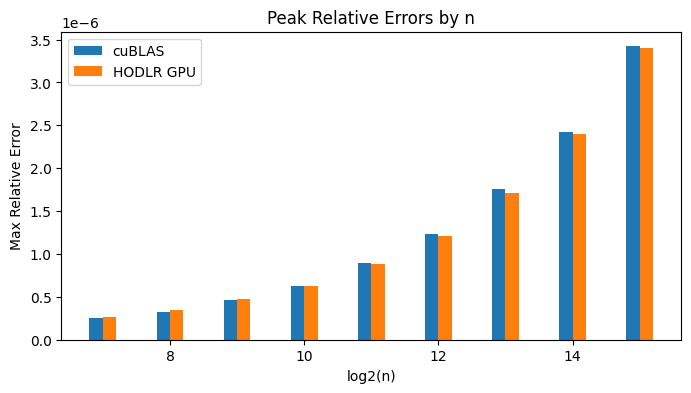

In [36]:
plt.figure(figsize=(8,4))
plt.bar(group["log_n"]-0.1, group["relerr_cublas"], width=0.2, label="cuBLAS")
plt.bar(group["log_n"]+0.1, group["relerr_custom"], width=0.2, label="HODLR GPU")
plt.xlabel("log2(n)")
plt.ylabel("Max Relative Error")
plt.legend()
plt.title("Peak Relative Errors by n")
plt.show()

Text(0.5, 0.92, 'Execution Time vs Matrix Size and Low-Rank Approximation')

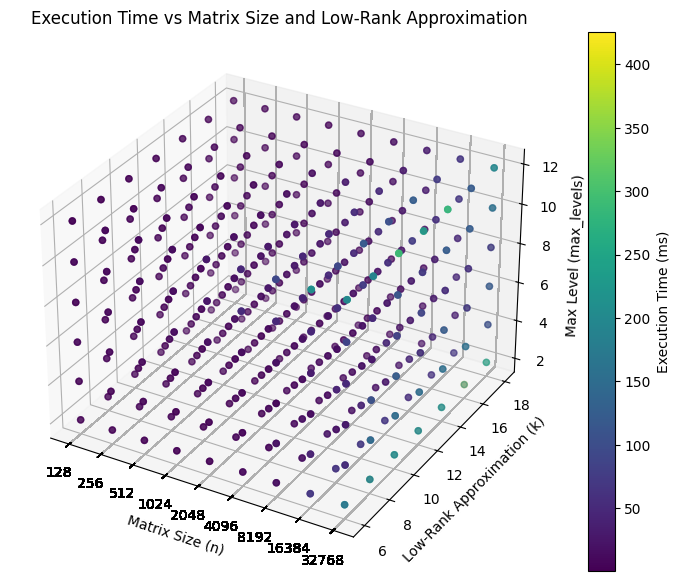

In [ ]:
X = np.log10(df['n'])
Y = df['k']
Z = df['max_levels']  # Replace with 'gpu_kernel_ms' or 'gpu_total_ms' as needed

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X, Y, Z, c=df['gpu_total_ms'], cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('Matrix Size (n)')
ax.set_ylabel('Low-Rank Approximation (k)')
ax.set_zlabel('Max Level (max_levels)')

tick_positions = np.log10(df['n'])
tick_labels = df['n']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Add color bar
fig.colorbar(scatter, ax=ax, label='Execution Time (ms)')

plt.title('Execution Time vs Matrix Size and Low-Rank Approximation')

In [37]:
import statsmodels.api as sm

# Define independent variables and dependent variable
X = df[['n', 'k', 'max_levels']]
y = df['gpu_kernel_ms']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gpu_kernel_ms   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     5.279
Date:                Tue, 29 Apr 2025   Prob (F-statistic):            0.00132
Time:                        11:56:31   Log-Likelihood:                -2210.9
No. Observations:                 756   AIC:                             4430.
Df Residuals:                     752   BIC:                             4448.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3884      0.630      2.204      0.0